## Import libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

## Load and transform the dataset

In [2]:
bsize = 64

# list all transformations
transform = transforms.Compose([transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bsize, shuffle=True)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bsize, shuffle=False)

## Visualise some data samples

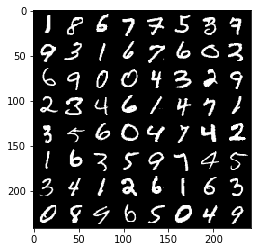

In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

## Define the model hyperparameters

In [4]:
# parameters 
input_dim = 28
temporal_dim = 28
hidden_dim = 150
output_dim = 10
num_epochs = 10

## Define the model architecture

In [5]:
class ImageClassifierRNN(nn.Module):
    def __init__(self, batch_size, input_dim, hidden_dim, output_dim):
        super(ImageClassifierRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.rnn = nn.RNN(self.input_dim, self.hidden_dim) 
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        
    def init_hidden(self,):
        return (torch.zeros(1, self.batch_size, self.hidden_dim))
        
    def forward(self, ip):
        # transforms X to dimensions: temporal_dim X bsize X input_dim
        ip = ip.permute(1, 0, 2) 
        
        self.batch_size = ip.size(1)
        self.hidden = self.init_hidden()
        
        # output_state => temporal_dim, bsize, hidden_dim (hidden states for each time step)
        # self.hidden => 1, bsize, hidden_dim (final state from each output_state)
        output_state, self.hidden = self.rnn(ip, self.hidden)      
        out = self.fc(self.hidden)
        
        return out.view(-1, self.output_dim) # bsize X output_dim

## Instantiate the RNN model 

In [6]:
model = ImageClassifierRNN(bsize, input_dim, hidden_dim, output_dim)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def accuracy(pred_prob, label, bsize):
    corrects = (torch.max(pred_prob, 1)[1].view(label.size()).data == label.data).sum()
    accuracy = (100.0 * corrects/bsize).item()
    return accuracy

## Run the model training loop

In [7]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    loss_epoch = 0.0
    acc_epoch = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, temporal_dim, input_dim) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_epoch += loss.detach().item()
        acc_epoch += accuracy(outputs, labels, bsize)
         
    model.eval()
    print(f"epoch number: {epoch}, loss: {loss_epoch/i}, accuracy: {acc_epoch/i}")

epoch number: 0, loss: 0.7086941472780488, accuracy: 76.84431696905015
epoch number: 1, loss: 0.31167542590116615, accuracy: 90.9034818569904
epoch number: 2, loss: 0.24152435692327381, accuracy: 93.13300426894344
epoch number: 3, loss: 0.19723613096625725, accuracy: 94.39367662753469
epoch number: 4, loss: 0.17153389536424787, accuracy: 95.1790955176094
epoch number: 5, loss: 0.15722338426878066, accuracy: 95.48759338313768
epoch number: 6, loss: 0.14421601161328934, accuracy: 95.98118996798293
epoch number: 7, loss: 0.1326703933686845, accuracy: 96.21965048025613
epoch number: 8, loss: 0.1259513002638422, accuracy: 96.43643276414087
epoch number: 9, loss: 0.11798972860396131, accuracy: 96.7315901814301


## Evaluate the model on test dataset

In [8]:
test_accuracy = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, temporal_dim, input_dim)
    outputs = model(inputs)
    test_accuracy += accuracy(outputs, labels, bsize)
        
print(f"accuracy on test set: {test_accuracy/i}")

accuracy on test set: 96.88501602564102


## Visualise predictions of the model against ground truth

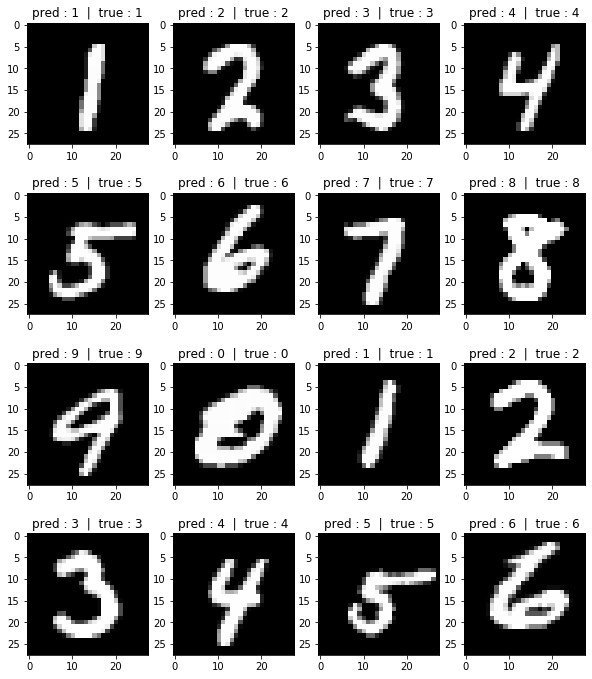

In [9]:
plt.subplots(4, 4, figsize=(10, 12))
for i in range(len(inputs)):
    plt.subplot(4, 4, i+1)
    plt.imshow(inputs[i], cmap="gray")
    plt.title(f"pred : {np.argmax(outputs[i].detach().numpy())}  |  true : {labels[i]}")